Jupyter notebook to test the functionality of QBE with access to a classical computer and quantum computer on which we run VQE for ground state preparation

In [1]:
# Imports
import os, sys, types
import pathlib
from importlib import reload
import pickle
import copy

import numpy as np
from matplotlib import pyplot as plt
import qiskit.quantum_info as qi
import h5py

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import IBMQ, BasicAer, Aer, transpile, assemble, execute

In [3]:
from qiskit.providers.aer import AerSimulator

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector, DensityMatrix

from qiskit.opflow import (PauliOp, SummedOp, PauliExpectation, PauliSumOp,
    OperatorBase,
    ExpectationBase,
    ExpectationFactory,
    StateFn,
    CircuitStateFn,
    ListOp,
    CircuitSampler,
)

In [5]:
# PySCFDriver is no longer a thing
from qiskit import Aer
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper

from qiskit_nature.circuit.library import HartreeFock, UCCSD, UCC
from qiskit_nature.algorithms import VQEUCCFactory, GroundStateEigensolver
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import L_BFGS_B, COBYLA, SPSA
from qiskit.algorithms import  MinimumEigensolver, VQE, NumPyMinimumEigensolver
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit.library import TwoLocal, ExcitationPreserving

In [6]:
# Local package imports
# Update this with setup & develop later
PROJECT_PATH = str(pathlib.Path().resolve().parent)
sys.path.append(PROJECT_PATH)

In [7]:
# Cool reloading
# Reference: https://stackoverflow.com/questions/28101895/reloading-packages-and-their-submodules-recursively-in-python

def reload_package(package):
    assert(hasattr(package, "__package__"))
    fn = package.__file__
    fn_dir = os.path.dirname(fn) + os.sep
    module_visit = {fn}
    del fn

    def reload_recursive_ex(module):
        reload(module)

        for module_child in vars(module).values():
            if isinstance(module_child, types.ModuleType):
                fn_child = getattr(module_child, "__file__", None)
                if (fn_child is not None) and fn_child.startswith(fn_dir):
                    if fn_child not in module_visit:
                        # print("reloading:", fn_child, "from", module)
                        module_visit.add(fn_child)
                        reload_recursive_ex(module_child)

    return reload_recursive_ex(package)

In [8]:
import qbe

/Users/arkopal/miniconda3/envs/qbe-qiskit/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [20]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [10]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.21.2', 'qiskit-aer': '0.10.4', 'qiskit-ignis': '0.7.0', 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.37.2', 'qiskit-nature': '0.4.4', 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

# 0. Step 0 VQE Run

## Example Run (from qiskit_nature)

In [12]:
# From qiskit_nature reference
molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]], charge=0, multiplicity=1
)
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)

es_problem = ElectronicStructureProblem(driver)
qubit_converter = QubitConverter(JordanWignerMapper())

second_q_ops = es_problem.second_q_ops()
#main_op = second_q_ops['ElectronicEnergy']
main_op = second_q_ops[0]

particle_number = es_problem.grouped_property_transformed.get_property("ParticleNumber")

num_particles = (particle_number.num_alpha, particle_number.num_beta)
num_spin_orbitals = particle_number.num_spin_orbitals

optimizer = L_BFGS_B()

mapper = JordanWignerMapper()
converter = QubitConverter(mapper=mapper)

qubit_op = converter.convert(main_op, num_particles=num_particles)

# setup the initial state for the ansatz
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

# setup the ansatz for VQE with initial state
#ansatz = TwoLocal(num_spin_orbitals, ['ry', 'rz'], 'cz', initial_state=init_state)
ansatz = UCCSD(converter, num_particles, num_spin_orbitals, reps=1, initial_state=init_state)

#backend = Aer.get_backend('aer_simulator_statevector')
backend = Aer.get_backend('statevector_simulator')

# setup and run VQE
algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend)

result = algorithm.compute_minimum_eigenvalue(qubit_op)
print(result.eigenvalue.real)

electronic_structure_result = es_problem.interpret(result)
print(electronic_structure_result)

/Users/arkopal/miniconda3/envs/qbe-qiskit/lib/python3.9/site-packages/qiskit_nature/problems/second_quantization/electronic/electronic_structure_problem.py:93: ListAuxOpsDeprecationWarning: List-based `aux_operators` are deprecated as of version 0.3.0 and support for them will be removed no sooner than 3 months after the release. Instead, use dict-based `aux_operators`. You can switch to the dict-based interface immediately, by setting `qiskit_nature.settings.dict_aux_operators` to `True`.
  second_quantized_ops = self._grouped_property_transformed.second_q_ops()


-1.8572750302023595
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 


In [13]:
ansatz.num_qubits

4

In [14]:
result.eigenvalue

(-1.8572750302023595+0j)

In [15]:
result.eigenstate

array([-2.03235497e-17-3.82361340e-17j,  1.60226762e-16-1.48549372e-16j,
       -6.02432951e-17+3.64874224e-17j,  4.09148174e-17+3.01366276e-17j,
       -1.87006803e-16-1.88092751e-16j,  9.93760413e-01-1.19742896e-15j,
        1.04067542e-08+6.97392060e-19j,  1.15565549e-17-2.19532476e-16j,
       -1.63655502e-18+4.39122379e-17j, -9.51912910e-09+4.01364503e-18j,
       -1.11535827e-01+1.58569283e-16j,  8.81299113e-17+1.82792325e-17j,
        3.18202856e-17+2.12375962e-17j, -1.66402376e-16-1.22456303e-16j,
        1.32151950e-18+1.68612666e-17j, -4.18799294e-17+2.53745237e-17j])

In [16]:
print(qubit_op)

-0.8105479805373264 * IIII
+ 0.1721839326191556 * IIIZ
- 0.2257534922240247 * IIZI
+ 0.17218393261915552 * IZII
- 0.22575349222402472 * ZIII
+ 0.12091263261776633 * IIZZ
+ 0.16892753870087912 * IZIZ
+ 0.04523279994605784 * YYYY
+ 0.04523279994605784 * XXYY
+ 0.04523279994605784 * YYXX
+ 0.04523279994605784 * XXXX
+ 0.16614543256382416 * ZIIZ
+ 0.16614543256382416 * IZZI
+ 0.17464343068300453 * ZIZI
+ 0.12091263261776633 * ZZII


In [17]:
# Ref: https://qiskit.org/documentation/tutorials/algorithms/03_vqe_simulation_with_noise.html
seed = 170
iterations = 125
algorithm_globals.random_seed = seed

#backend = Aer.get_backend('aer_simulator')
#backend = Aer.get_backend('statevector_simulator')
backend = Aer.get_backend('aer_simulator_statevector')

qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
H2_op = qubit_op # from above

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=qubit_op)
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')

VQE on Aer qasm simulator (no noise): -1.83275


In [18]:
result.eigenstate

array([ 0.03174993+0.j, -0.04738728+0.j, -0.04311075+0.j,  0.00306663+0.j,
        0.03697076+0.j,  0.99165164+0.j, -0.02047615+0.j,  0.05435274+0.j,
       -0.00471925+0.j,  0.00969005+0.j, -0.03338707-0.j,  0.00670691+0.j,
        0.05427801+0.j, -0.00226006+0.j, -0.05032805+0.j, -0.00227594+0.j])

In [19]:
result.eigenvalue

(-1.8327450331329216+0j)

## 0.0 Physics vs Qiskit ordering

In [19]:
molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                              ['H', [0., 0., 0.735]]],
                     charge=0, multiplicity=1)
driver = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM, basis='sto3g')

# Electronic Structure
es_problem = ElectronicStructureProblem(driver)
second_q_op = es_problem.second_q_ops()

qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
qubit_op = qubit_converter.convert(second_q_op[0])

NameError: name 'PySCFDriver' is not defined

In [ ]:
qubit_op

## 0.1 4-qubit toy problem

In [20]:
reload_package(qbe)

In [21]:
# Load the hamiltonian
num_qubits = 3

H1 = np.load('frag_A_4qubit.npy')
H2 = np.load('frag_B_4qubit.npy')
full_H = np.load('full_H_4qubit.npy')

In [22]:
# Fragment information
n_frags = 2
n_qubits = 3

labels_fragments = ['0', '1']
fragment_info = {'0': [0,1,2], '1': [0,1,2]}
fragment_nb = {'0':{'1': {'n_sites': 1, 'edge': [(2,1)], 'center': [(1,0)]} }, 
               '1':{'0': {'n_sites': 1, 'edge': [(0,1)], 'center': [(1,2)]} }}

fragment_H_init = {'0': H1.copy(), '1': H2.copy()}

In [23]:
# Classical solver
gs_energy, gs_vec = qbe.fragment_hamiltonian.get_ground_state(H1)

In [24]:
gs_energy

-1.3018744287965

In [25]:
gs_vec

array([-0.44351844+0.j        , -0.17059144+0.21172838j,
        0.28672998+0.06741255j,  0.51033266-0.00325658j,
       -0.16682046+0.3191485j ,  0.15084195+0.10106272j,
       -0.24395801-0.33502712j,  0.02166647-0.21742257j])

In [26]:
# What's the spectral gap of the above Hamiltonian? Ideally, we want to measure the GS Energy within this.
evalues, evectors = np.linalg.eigh(H1)

# smallest two eigenvalues
E0, E1 = np.partition(evalues, 1)[0:2] 

spec_gap = E1 - E0
print('Spectral Gap = %f' %spec_gap)
print('Ideal estimation error = %f' %(spec_gap/8))

Spectral Gap = 0.280287
Ideal estimation error = 0.035036


In [27]:
# Create an initial state of |+>^n
plus_state = QuantumCircuit(n_qubits)
plus_state.h(0)
plus_state.h(1)
plus_state.h(2)

In [28]:
# Create maximally mixed state |0>^n + |1>^n
max_mix_state = QuantumCircuit(n_qubits)
max_mix_state.h(0)
max_mix_state.cx(0,1)
max_mix_state.cx(0,2)

In [29]:
backend = Aer.get_backend('aer_simulator_statevector')
#backend = Aer.get_backend('statevector_simulator')
#backend = Aer.get_backend('aer_simulator')

ansatz = TwoLocal(3, ['ry','rz'], 'cz', 'full', reps=8, initial_state=plus_state)
#ansatz = TwoLocal(3, ['ry','rz'], 'cz', 'full', reps=3, initial_state=max_mix_state)

In [30]:
# Initialize QBEVQESolver
vqe_solver = qbe.QBEVQESolver(n_qubits=3, ansatz=ansatz, backend=backend)

In [31]:
# Use VQE to solver for ground state energy and gs vector
est_gs_energy, est_gs_vec = vqe_solver.compute_ground_state(H1)
#result = vqe_solver.compute_ground_state(H1, ansatz, backend)

In [32]:
est_gs_energy

(-1.264561949493795+0j)

In [33]:
# Estimation error
print('Estimation error = %f' %(est_gs_energy.real - gs_energy))

Estimation error = 0.037312


In [34]:
est_gs_vec

array([ 0.34100764-0.21111074j, -0.05085811-0.31319095j,
       -0.16738989+0.11104059j, -0.38342238+0.44305996j,
       -0.15430402-0.32063075j, -0.13538664-0.08773473j,
        0.37810129+0.10959395j,  0.16060481+0.14628952j])

In [35]:
gs_vec

array([-0.44351844+0.j        , -0.17059144+0.21172838j,
        0.28672998+0.06741255j,  0.51033266-0.00325658j,
       -0.16682046+0.3191485j ,  0.15084195+0.10106272j,
       -0.24395801-0.33502712j,  0.02166647-0.21742257j])

In [36]:
#est_gs_vec = result.eigenstate
ratio_gs = est_gs_vec/gs_vec
print(ratio_gs)
#[np.arctan(r) for r in ratio_gs]

[-0.76886914+0.47599091j -0.77959129+0.86832816j -0.46693009+0.49704444j
 -0.75682779+0.86334921j -0.59056836+0.79217952j -0.88842555+0.01360347j
 -0.75080794+0.58185045j -0.59333285+0.79780236j]


physics vs qubit orderings

In [37]:
n_qubits = 3
n_strings = 2**n_qubits

list_integers_qo = np.arange(2**n_qubits)
binary_strings_qo = [np.binary_repr(list_integers_qo[ind], width=n_qubits) for ind in range(n_strings)]

binary_strings_po = [binary_strings_qo[ind][::-1] for ind in range(n_strings)]
list_integers_po = [int(binary_strings_po[ind], 2) for ind in range(n_strings)]

mapping_qo_to_po = np.argsort(list_integers_po)

In [38]:
binary_strings_qo

['000', '001', '010', '011', '100', '101', '110', '111']

In [39]:
binary_strings_po

['000', '100', '010', '110', '001', '101', '011', '111']

In [40]:
cp_binary_strings_po = binary_strings_po.copy()
for ind in range(n_strings):
    cp_binary_strings_po[ind] = binary_strings_po[mapping_qo_to_po[ind]]

In [41]:
cp_binary_strings_po

['000', '001', '010', '011', '100', '101', '110', '111']

# 1. 4-qubit toy problem

## Hamiltonian of interest

In [11]:
# toy problem
num_qubits = 3

H1 = np.load('frag_A_4qubit.npy')
H2 = np.load('frag_B_4qubit.npy')
full_H = np.load('full_H_4qubit.npy')

In [12]:
# Fragment information
n_frags = 2
n_qubits = 3

labels_fragments = ['0', '1']
fragment_info = {'0': [0,1,2], '1': [0,1,2]}
fragment_nb = {'0':{'1': {'n_sites': 1, 'edge': [(2,1)], 'center': [(1,0)]} }, 
               '1':{'0': {'n_sites': 1, 'edge': [(0,1)], 'center': [(1,2)]} }}

fragment_H_init = {'0': H1.copy(), '1': H2.copy()}

#lagrange_multipliers = {'0':{'1': 0}, '1':{'0': 0}}
#rhoEA_minus_rhoCB = {'0':{'1': [np.matrix(np.zeros(2**num_qubits))]}, '1':{'0': [np.matrix(np.zeros(2**num_qubits))]}}

In [13]:
qbe_fragment_init = qbe.fragment_hamiltonian.qbe_fragment_qubit(n_frags, n_qubits, labels_fragments,
                                                                fragment_info, 
                                                                fragment_nb, fragment_H_init)

In [14]:
qbe_fragment_init.gs_energies

{'0': -1.3018744287965, '1': -1.4517648157734904}

## Linear Constraints + Classical Solver

In [15]:
reload_package(qbe)

In [16]:
qbe_fragment_lin_classical = copy.deepcopy(qbe_fragment_init)

In [17]:
func_updating_LR = lambda LR_init, n_iter: LR_init*(10**(-n_iter/50))

optimizer_options = {'max_iters': 150, 'LR_init': 0.1, 
                     'LR_schedule': None,
                     'n_gd_iters': 10, 'THRES_GRAD': 1e-8}
qbe_solver_lin_classical = qbe.quantum_bootstrap.qbe_solver_qubit(qbe_fragment_lin_classical, type_constraint='linear',
                                                       optimizer_options=optimizer_options)

In [18]:
ds_classical_lin = qbe_solver_lin_classical.gd_solve()

Iter. number: 0
Iter. number: 1
Iter. number: 2
Iter. number: 3
Iter. number: 4
Iter. number: 5
Iter. number: 6
Iter. number: 7
Iter. number: 8
Iter. number: 9
Iter. number: 10
Iter. number: 11
Iter. number: 12
Iter. number: 13
Iter. number: 14
Iter. number: 15
Iter. number: 16
Iter. number: 17
Iter. number: 18
Iter. number: 19
Iter. number: 20
Iter. number: 21
Iter. number: 22
Iter. number: 23
Iter. number: 24
Iter. number: 25
Iter. number: 26
Iter. number: 27
Iter. number: 28
Iter. number: 29
Iter. number: 30
Iter. number: 31
Iter. number: 32
Iter. number: 33
Iter. number: 34
Iter. number: 35
Iter. number: 36
Iter. number: 37
Iter. number: 38
Iter. number: 39
Iter. number: 40
Iter. number: 41
Iter. number: 42
Iter. number: 43
Iter. number: 44
Iter. number: 45
Iter. number: 46
Iter. number: 47
Iter. number: 48
Iter. number: 49
Iter. number: 50
Iter. number: 51
Iter. number: 52
Iter. number: 53
Iter. number: 54
Iter. number: 55
Iter. number: 56


Text(0, 0.5, 'gradient after gradient descent \n(average over fragments)')

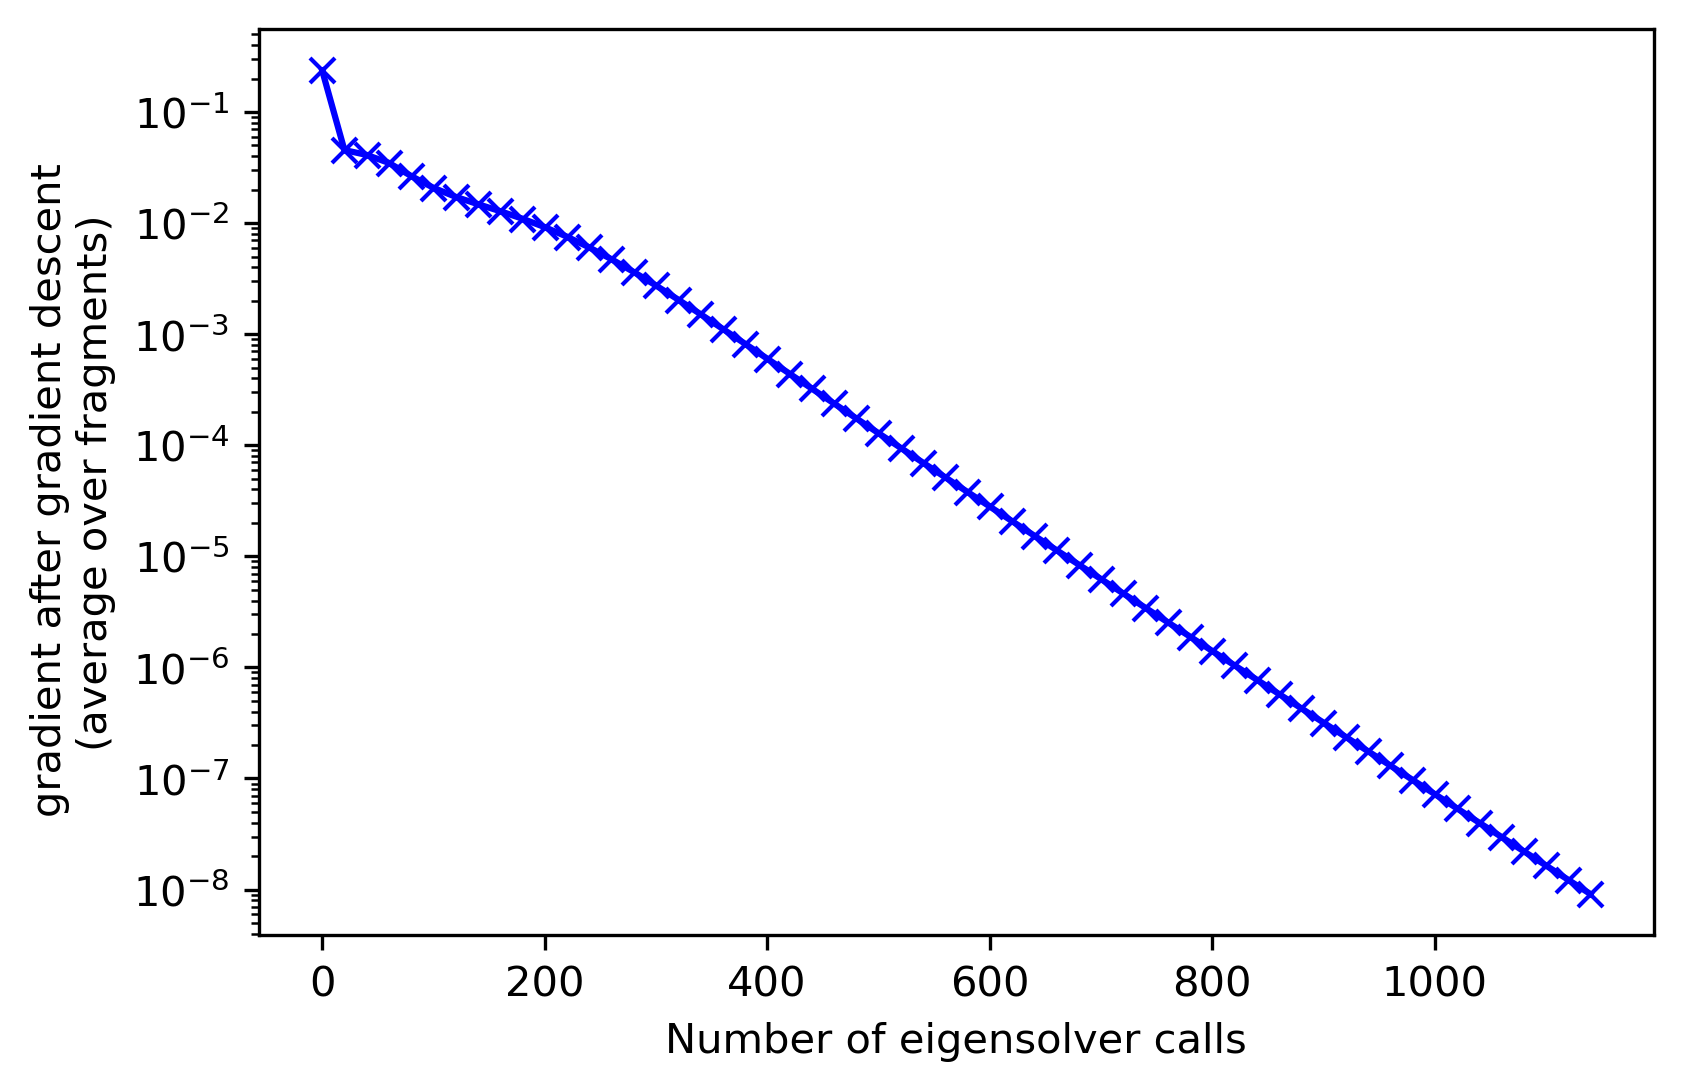

In [21]:
# Plotting
n_iter_classical = ds_classical_lin['iterations']
norm_gradients_classical = ds_classical_lin['norm_gradients']
rmse_error_classical = ds_classical_lin['rmse_error_fragment_rho']
n_eig_calls_classical = ds_classical_lin['n_eig_calls']

plt.figure(dpi = 150)
plt.semilogy(n_eig_calls_classical, norm_gradients_classical, '-x', c='b')
#plt.xlabel('iteration number (biggest loop)')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('gradient after gradient descent \n(average over fragments)')

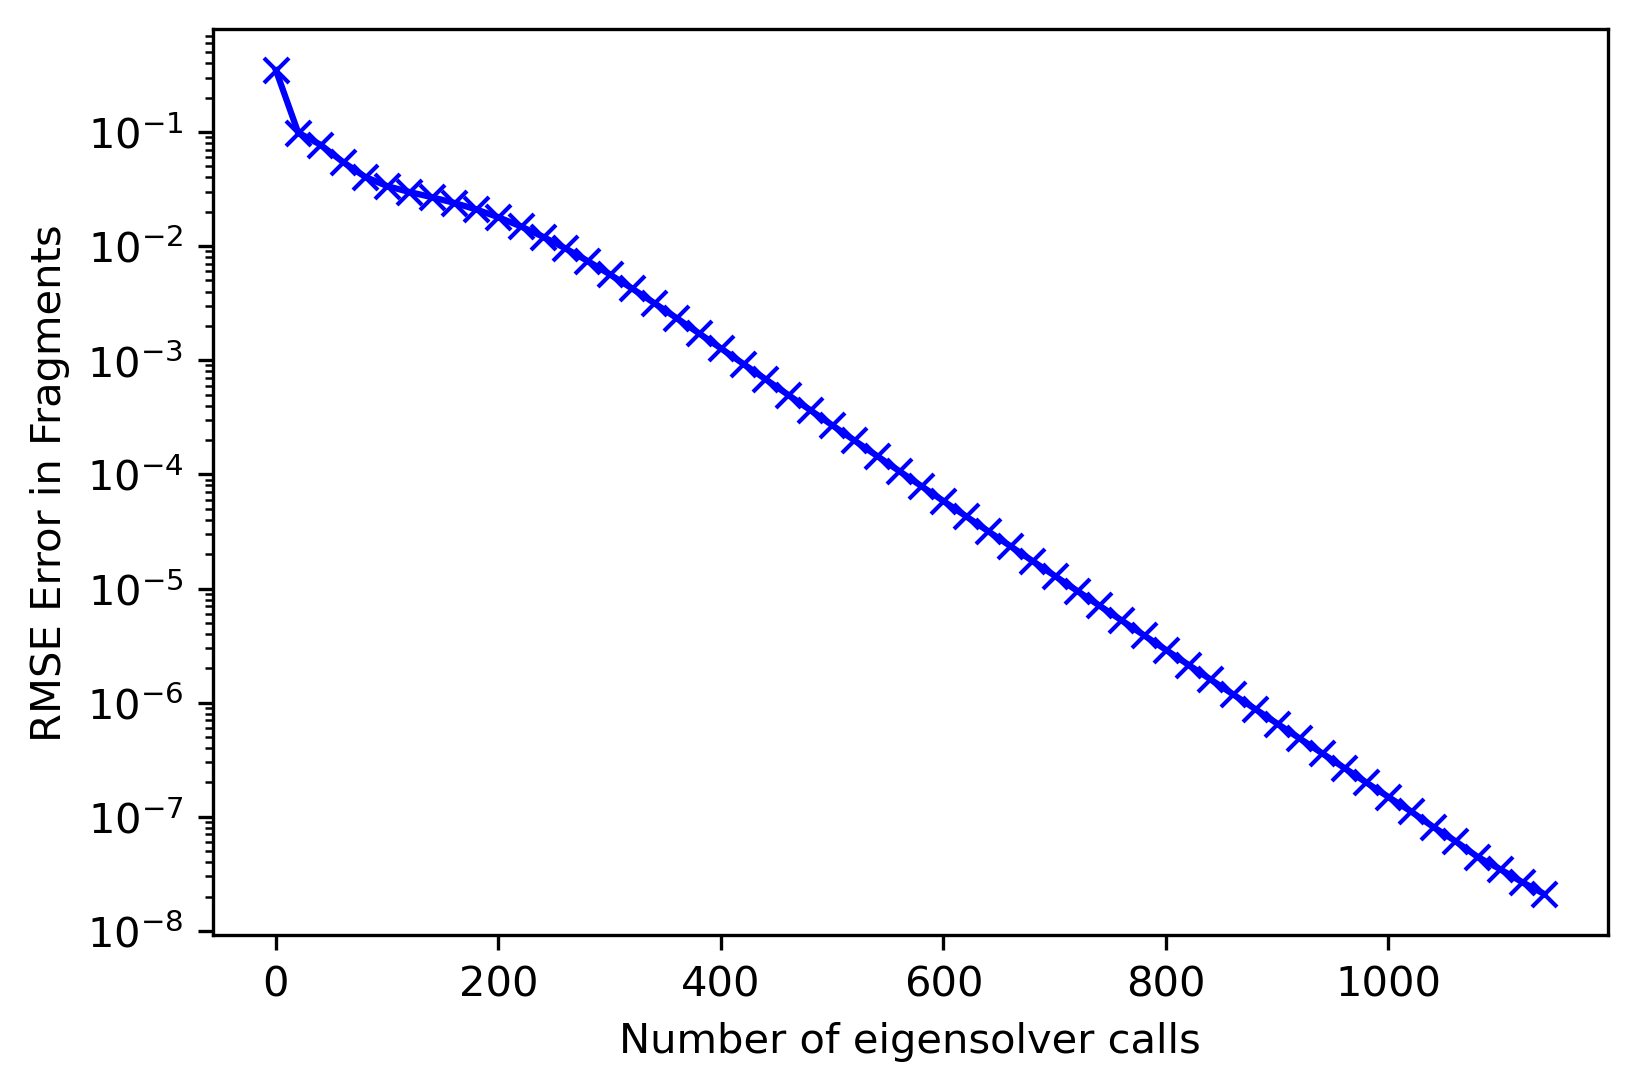

In [22]:
# Plot of RMSE Error in Fragments
plt.figure(dpi = 150)
plt.semilogy(n_eig_calls_classical, rmse_error_classical, '-x', c='b')
#plt.xlabel('iteration number (biggest loop)')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('RMSE Error in Fragments')
plt.show()

## Linear Constraints + VQE Solver

### Setup VQE Solver

In [151]:
# Create an initial state
plus_state = QuantumCircuit(n_qubits)
plus_state.h(0)
plus_state.h(1)
plus_state.h(2)

# ansatz
ansatz = TwoLocal(3, ['ry','rz'], 'cz', 'full', reps=8, initial_state=plus_state)

#ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz', reps=8, initial_state=plus_state)
#ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz', reps=8, initial_state=plus_state)

# backend
#backend = Aer.get_backend('aer_simulator_statevector')
backend = Aer.get_backend('statevector_simulator')
#backend = Aer.get_backend('aer_simulator')

In [152]:
# Initialize QBEVQESolver
vqe_solver = qbe.QBEVQESolver(n_qubits=3, ansatz=ansatz, backend=backend)

### VQE Solve (with ICs)

In [153]:
qbe_fragment_lin_vqe = copy.deepcopy(qbe_fragment_init)

In [154]:
qbe_fragment_lin_vqe.gs_energies

{'0': -1.3018744287965, '1': -1.4517648157734904}

In [155]:
# What are we aiming for?
qbe_fragment_lin_classical.gs_energies

{'0': -1.1247209785465466, '1': -1.238495966746822}

In [156]:
max_iters = 10
func_updating_LR = lambda LR_init, n_iter: LR_init*(1 - n_iter/(5*max_iters))

# optimizer_options = {'max_iters': max_iters, 'LR_init': 0.2, 
#                      'LR_schedule': func_updating_LR,
#                      'n_gd_iters': 3, 'THRES_GRAD': 1e-9}

optimizer_options = {'max_iters': max_iters, 'LR_init': 0.1, 
                     'LR_schedule': None,
                     'n_gd_iters': 10, 'THRES_GRAD': 1e-9}

type_gs_solver = 'vqe'
qbe_solver_lin_vqe = qbe.quantum_bootstrap.qbe_solver_qubit(qbe_fragment_lin_vqe, type_constraint='linear',
                                                            type_gs_solver=type_gs_solver,
                                                            gs_solver=vqe_solver,
                                                            optimizer_options=optimizer_options)

In [157]:
ds_lin = qbe_solver_lin_vqe.gd_solve()

Iter. number: 0
Iter. number: 1
Iter. number: 2
Iter. number: 3
Iter. number: 4
Iter. number: 5
Iter. number: 6
Iter. number: 7
Iter. number: 8
Iter. number: 9


Text(0, 0.5, 'gradient after gradient descent \n(average over fragments)')

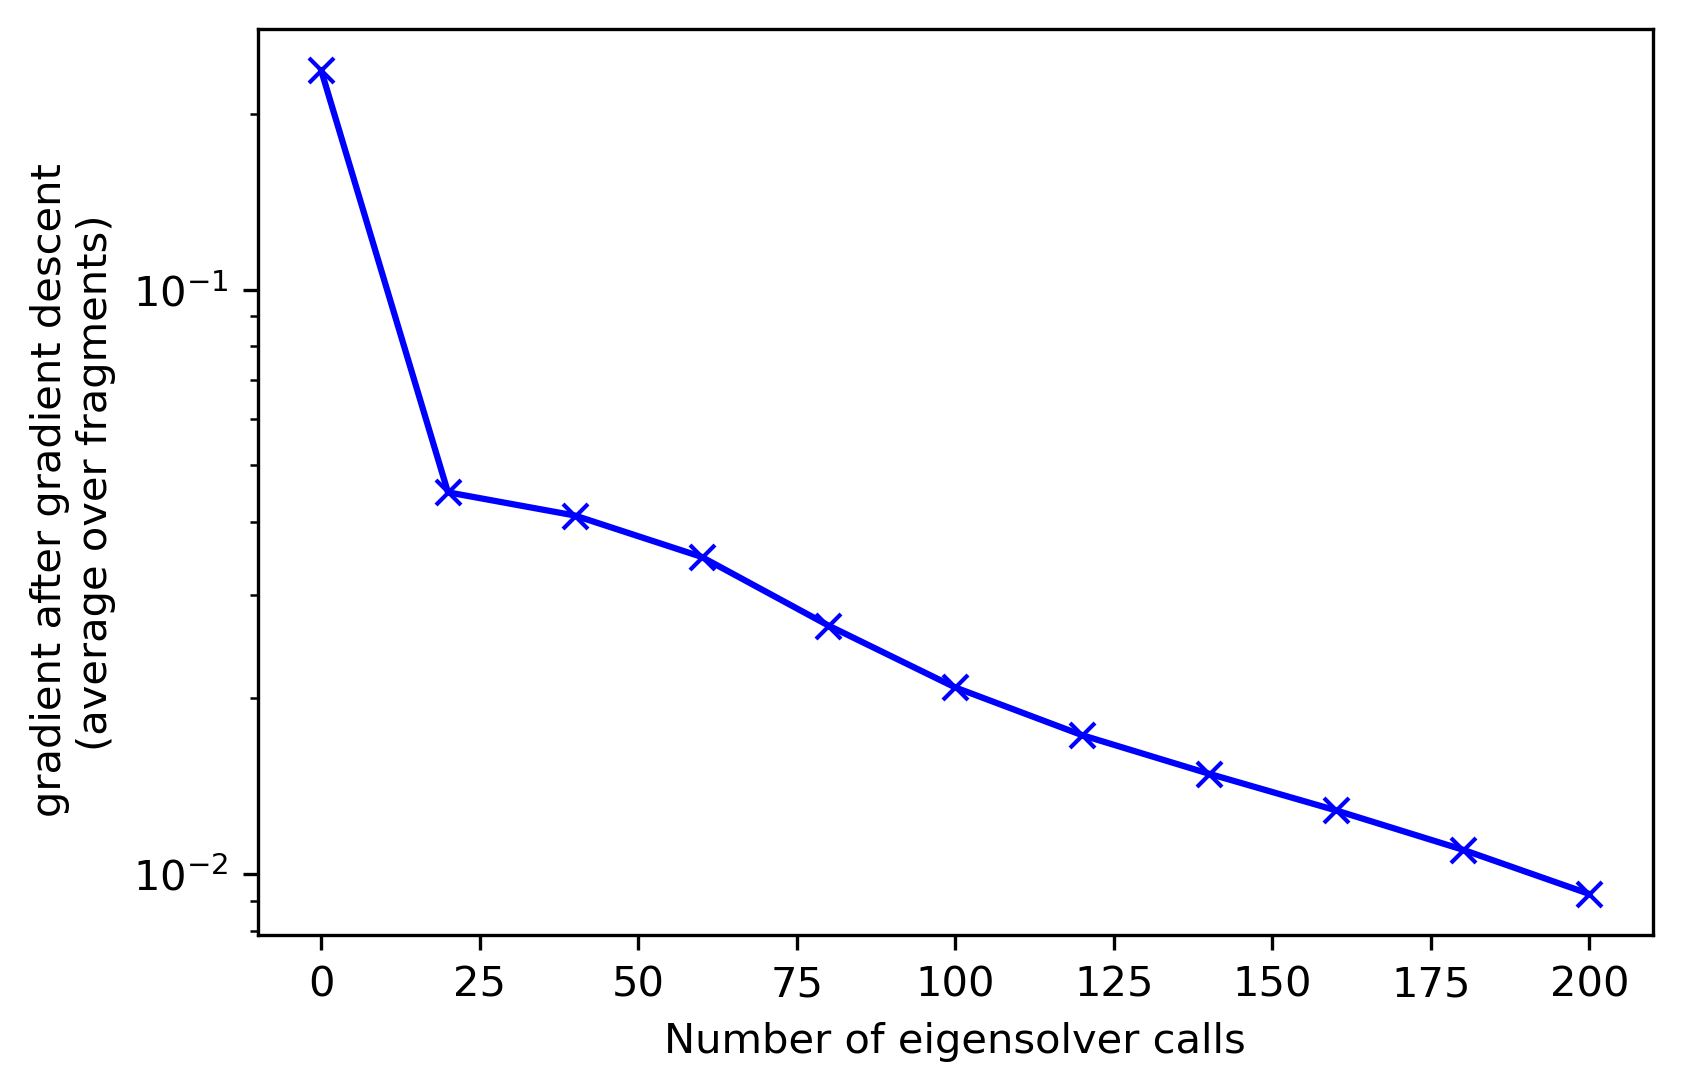

In [159]:
# Plotting
n_iter_vqe = ds_lin['iterations']
norm_gradients_vqe = ds_lin['norm_gradients']
rmse_error_vqe = ds_lin['rmse_error_fragment_rho']
n_eig_calls_vqe = ds_lin['n_eig_calls']

plt.figure(dpi = 150)
plt.semilogy(n_eig_calls_vqe, norm_gradients_vqe, '-x', c='b')
#plt.xlabel('iteration number (biggest loop)')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('gradient after gradient descent \n(average over fragments)')

Text(0, 0.5, 'RMSE Error in Fragments')

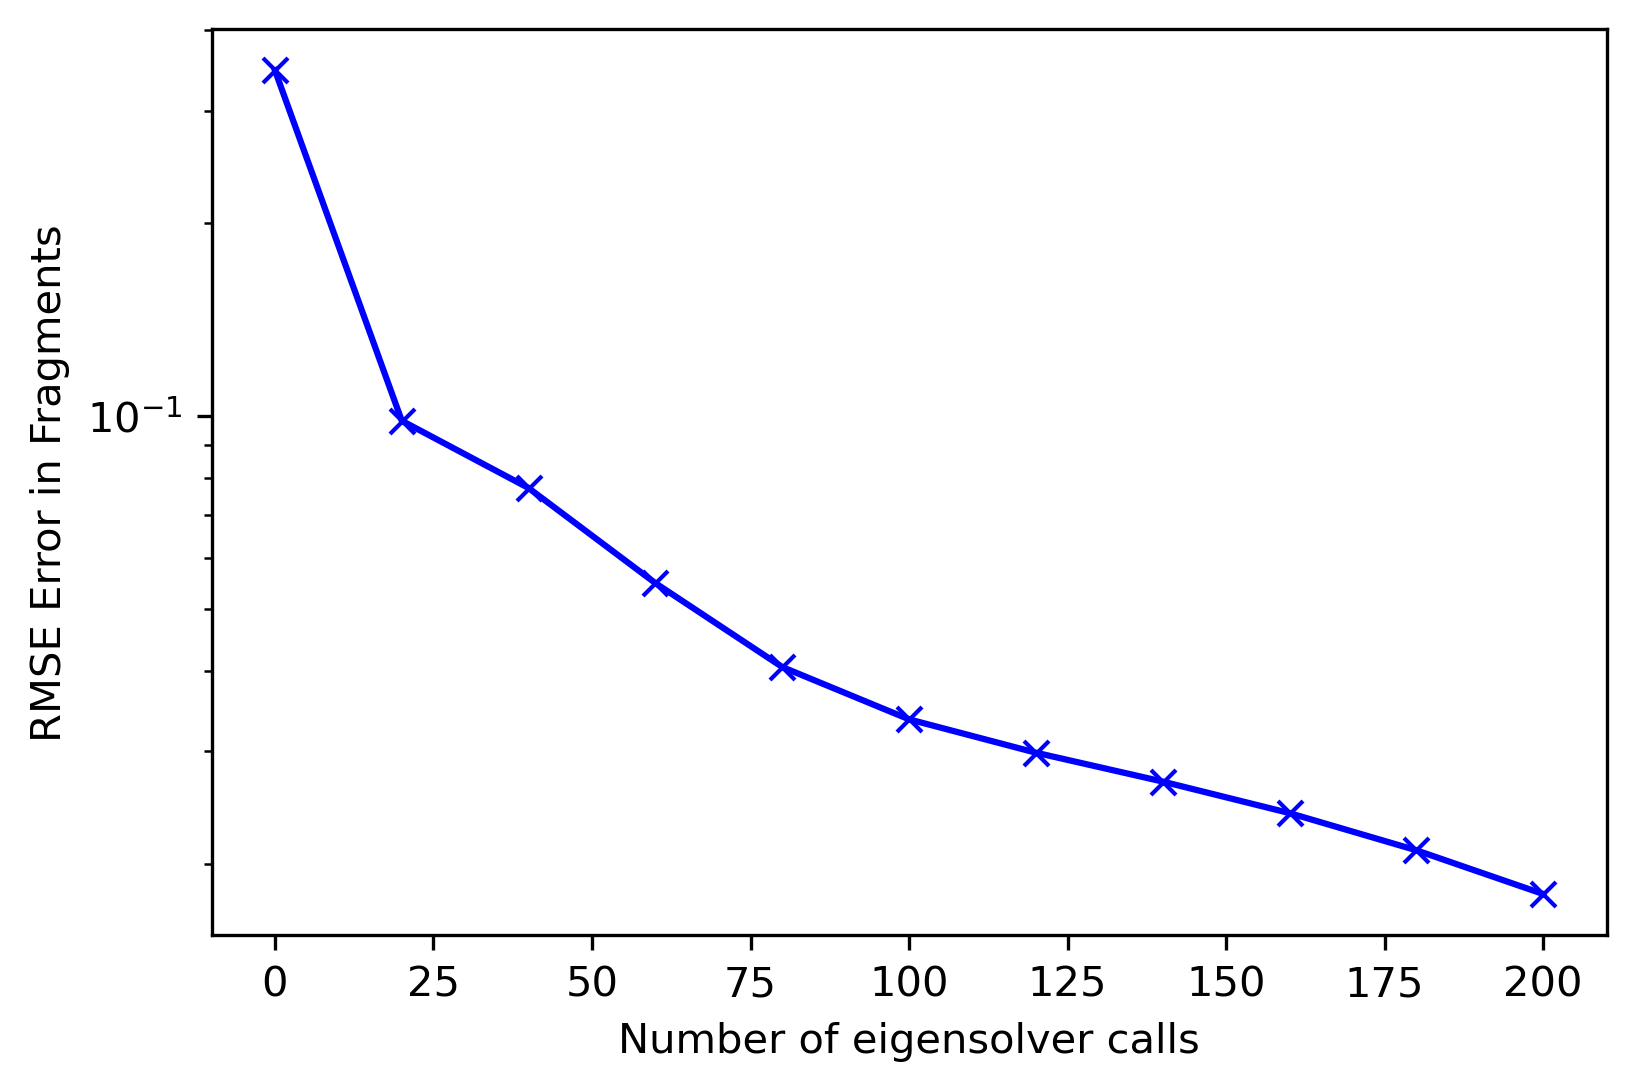

In [160]:
# Plot of RMSE Error in Fragments
plt.figure(dpi = 150)
plt.semilogy(n_eig_calls_vqe, rmse_error_vqe, '-x', c='b')
#plt.xlabel('iteration number (biggest loop)')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('RMSE Error in Fragments')

### Load runs

In [26]:
n_runs = 120
max_iters = 31

list_save_dir = '../jobs_vqe/toymodel_linear_vqe_gd_001/log_runs'

In [27]:
emp_est = qbe.utils.job_processor.EmpiricalEstimator(list_save_dir, max_iters=max_iters)
rmse_mean, rmse_std = emp_est.plot_rmse()
n_eig_calls = emp_est.job_results['neig_calls'][0]

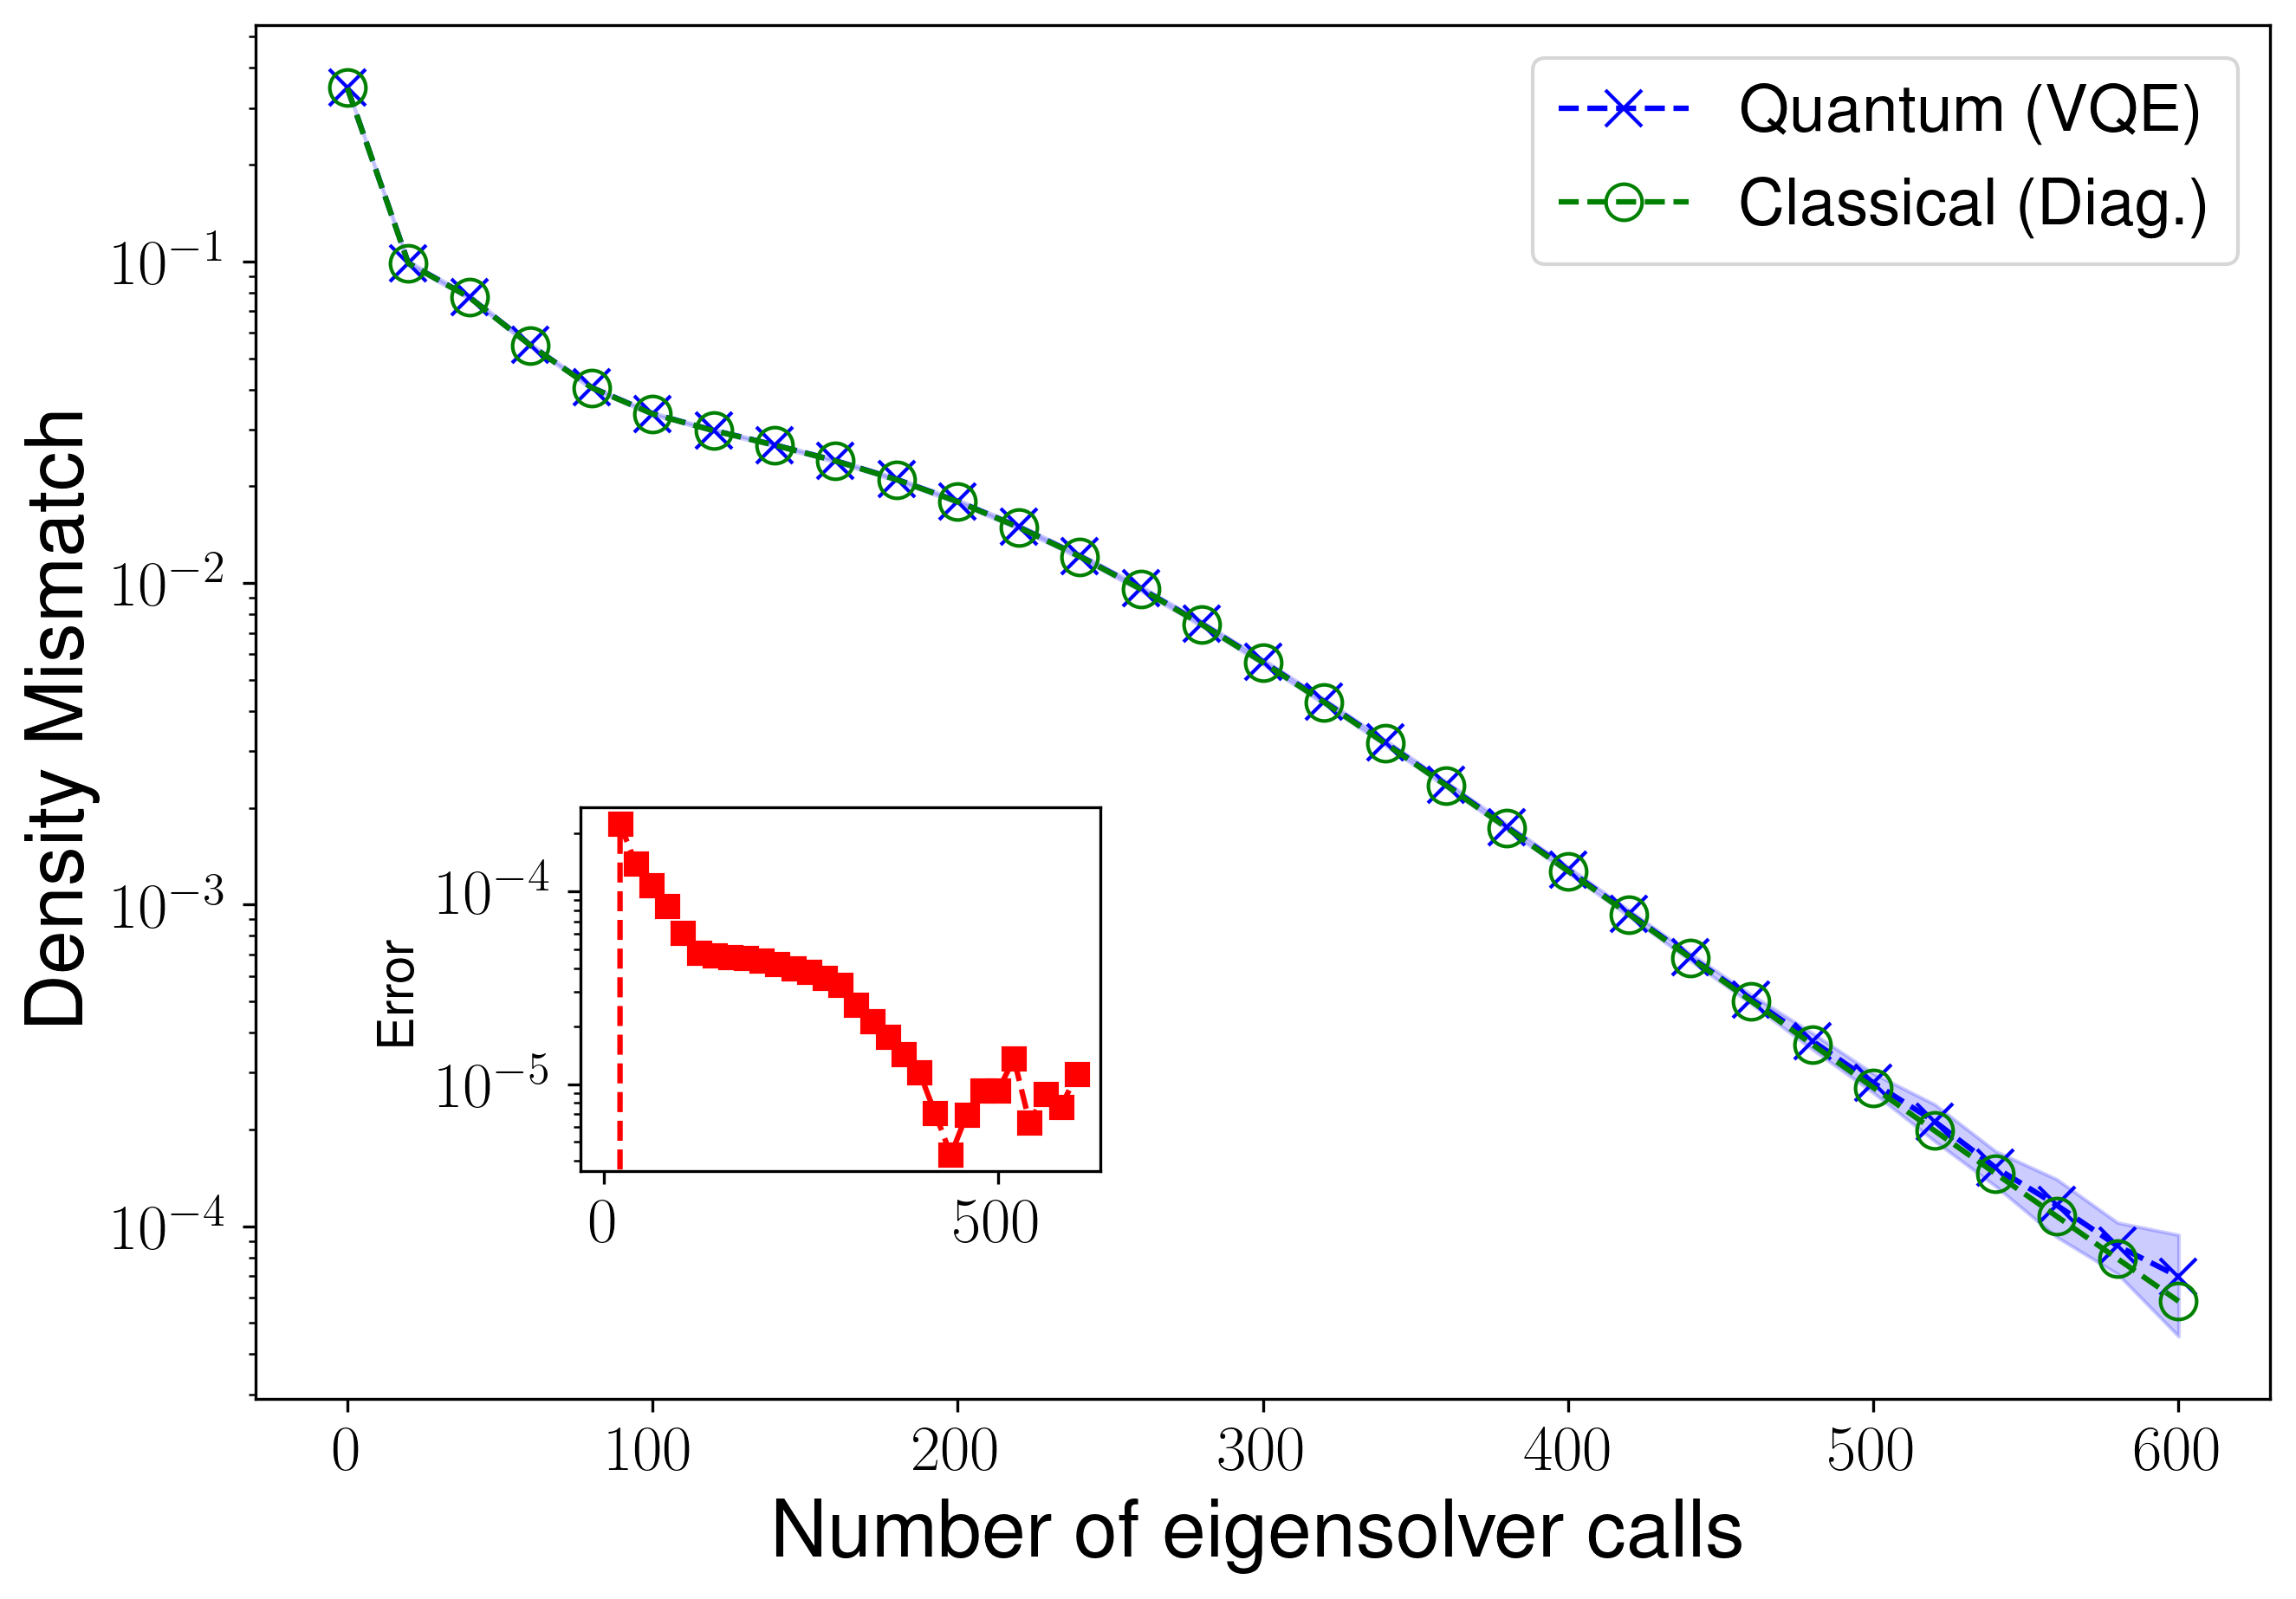

In [42]:
plt_fig = plt.figure(figsize=(10,7), dpi=150)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

plt.plot(n_eig_calls, rmse_mean, '--x', c='b', ms=10, mfc='None', label='Quantum (VQE)')
plt.semilogy(n_eig_calls_classical[:31], rmse_error_classical[:31], '--o', ms=10,
             mfc='None',c='g', label='Classical (Diag.)')

plt.fill_between(n_eig_calls, rmse_mean-rmse_std, rmse_mean+rmse_std,
                                 color='b', alpha=0.2)
plt.yscale('log')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('Density Mismatch')
plt.legend(loc='upper right')

# Inset of errors
left, bottom, width, height = [0.25, 0.25, 0.2, 0.2]
ax2 = plt_fig.add_axes([left, bottom, width, height])

ax2.semilogy(n_eig_calls, np.abs(rmse_mean-rmse_error_classical[:31]), '--s', c='red')
ax2.set_ylabel('Error', fontsize=14)

plt.savefig('comparison_rmse_classical_vqe_toy_problem_v1.png', bbox_inches='tight')
plt.show()

## Summary

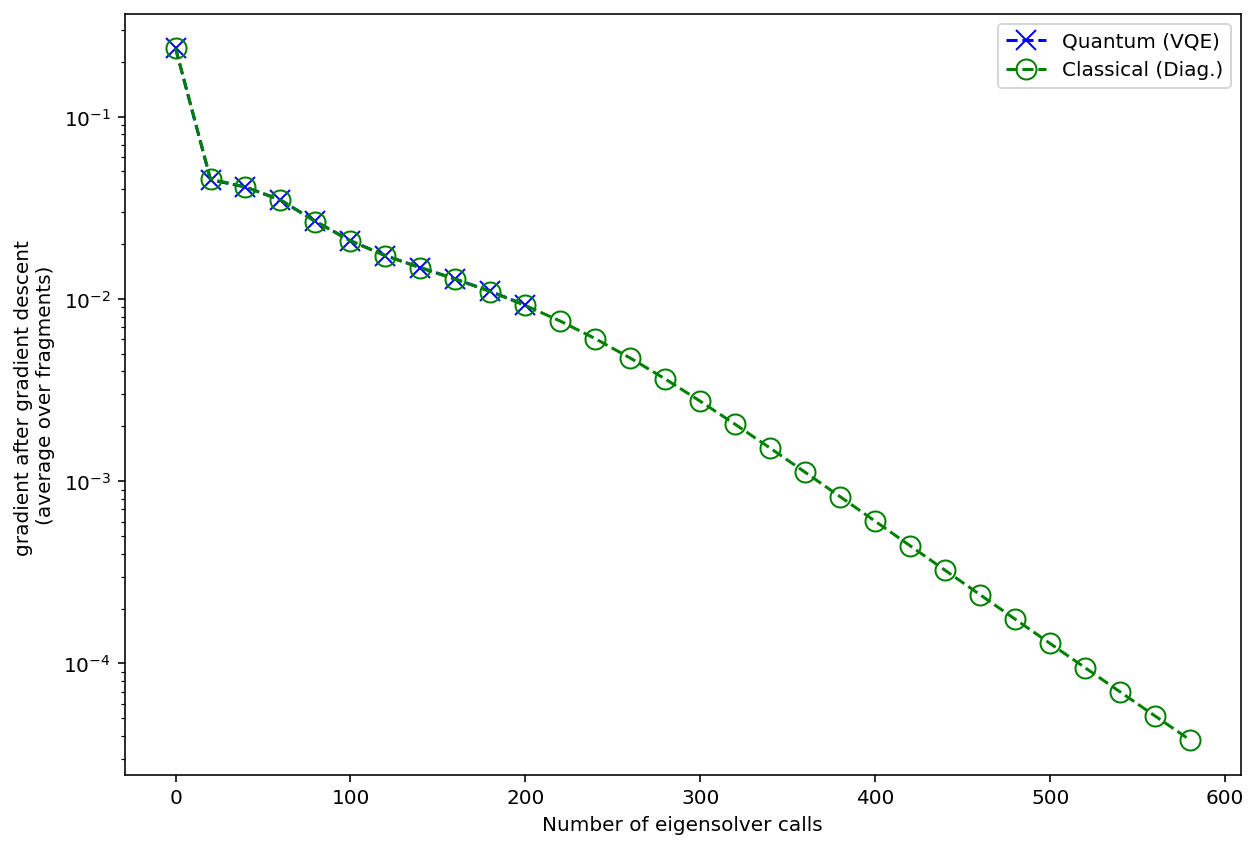

In [176]:
plt.figure(figsize=(10,7), dpi = 150)
plt.semilogy(n_eig_calls_vqe, norm_gradients_vqe, '--x', c='b', ms=10, label='Quantum (VQE)')
plt.semilogy(n_eig_calls_classical[:30], norm_gradients_classical[:30], '--o', ms=10,
             mfc='None',c='g', label='Classical (Diag.)')

plt.xlabel('Number of eigensolver calls')
plt.ylabel('gradient after gradient descent \n(average over fragments)')
plt.legend(loc='upper right')
plt.savefig('comparison_gradients_toy_problem2.png', bbox_inches='tight')

In [178]:
norm_gradients_classical[:30]

[0.23719669288672612,
 0.04545844122952857,
 0.041078763410942645,
 0.03483013198894648,
 0.026542658678707594,
 0.020788999846469175,
 0.017236524316062672,
 0.014805272422756689,
 0.012806180467310269,
 0.010960463155535088,
 0.009201918654427021,
 0.0075490944161642525,
 0.006046179039403965,
 0.004733584717254829,
 0.00363316635683041,
 0.0027444603167516663,
 0.0020488223090802025,
 0.0015172554962769778,
 0.001117963887660926,
 0.0008214224153668497,
 0.0006027373288225862,
 0.0004421186411350392,
 0.00032438991220424174,
 0.00023816404287477683,
 0.00017500793495403105,
 0.00012872355116461584,
 9.477473990178917e-05,
 6.984853671302786e-05,
 5.15270657675306e-05,
 3.804543926723876e-05]

In [179]:
norm_gradients_vqe[:10] - norm_gradients_classical[:30]

[0.23719669288672612,
 0.04497436952750072,
 0.04104823684661218,
 0.034869203628080374,
 0.02660787095444418,
 0.020847160111547757,
 0.01727407805205873,
 0.014839279181068175,
 0.012847006890971485,
 0.01100424265129312,
 0.00923814711253847]

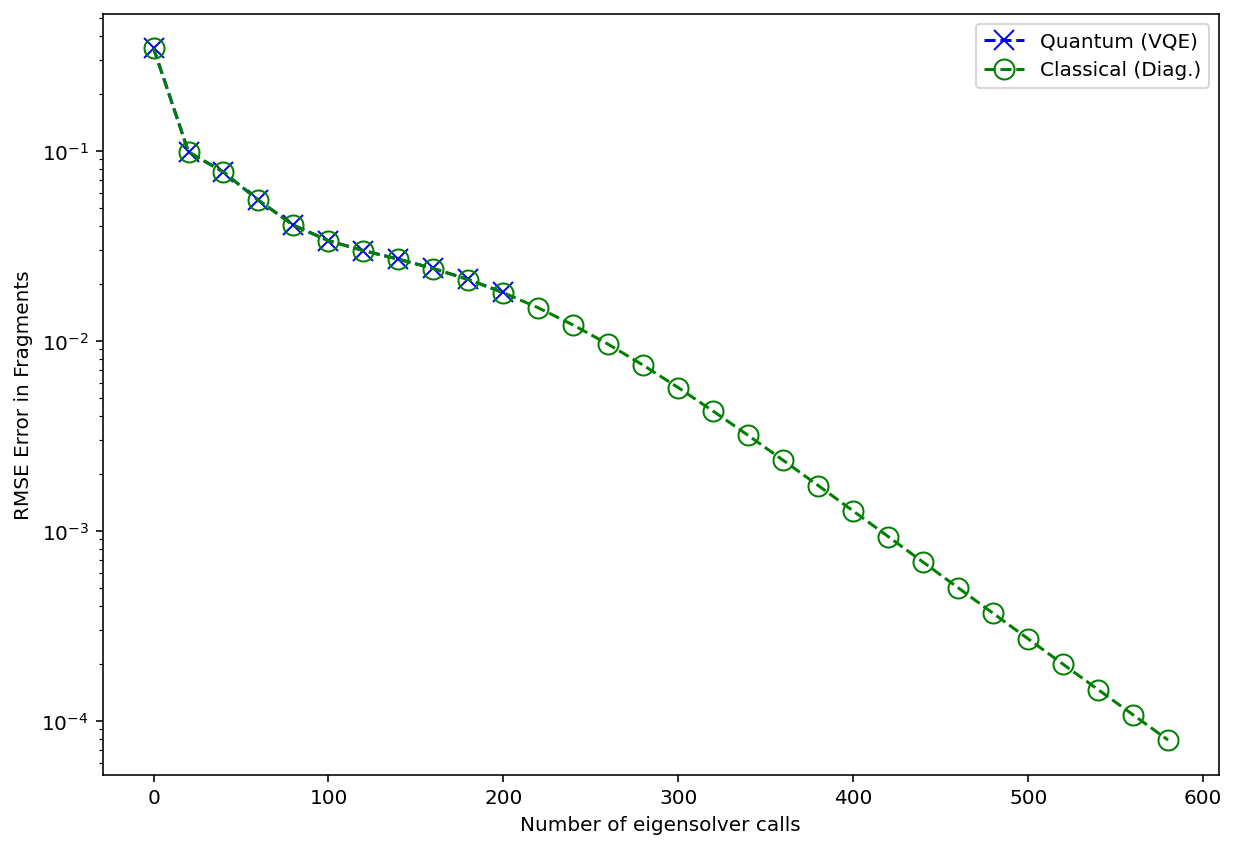

In [177]:
plt.figure(figsize=(10,7), dpi = 150)
plt.semilogy(n_eig_calls_vqe, rmse_error_vqe, '--x', c='b', ms=10, label='Quantum (VQE)')
plt.semilogy(n_eig_calls_classical[:30], rmse_error_classical[:30], '--o', ms=10,
             mfc='None',c='g', label='Classical (Diag.)')

plt.xlabel('Number of eigensolver calls')
plt.ylabel('RMSE Error in Fragments')
plt.legend(loc='upper right')
plt.savefig('comparison_rmse_toy_problem2.png', bbox_inches='tight')

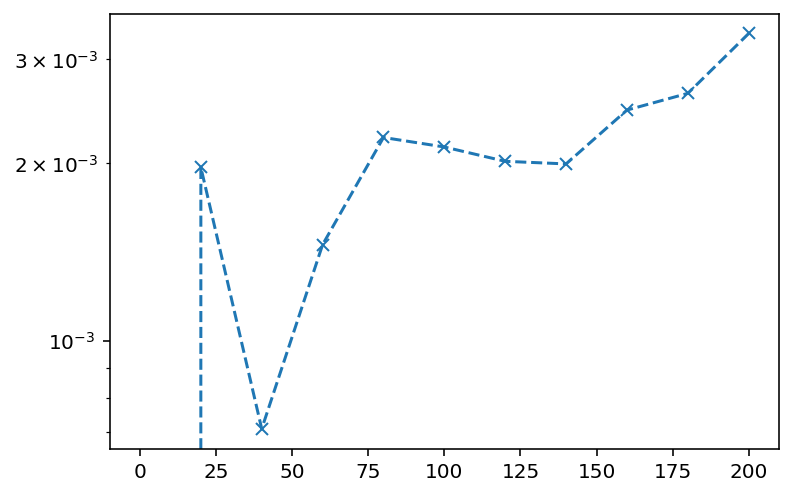

In [186]:
_n_iters = 11
diff_rmse = np.array(rmse_error_vqe) - np.array(rmse_error_classical)[:_n_iters]
diff_rmse = np.abs(diff_rmse)
rel_rmse = diff_rmse/np.abs(np.array(rmse_error_classical)[:_n_iters])

plt.semilogy(n_eig_calls_vqe, rel_rmse, '--x')